In [1]:
import pandas as pd
import numpy as np
import geopandas as gp
from unidecode import unidecode

# Argentinian provinces that make up 85% of its wheat production
relevant_areas = ['Buenos Aires', 'Córdoba', 'Entre Ríos', 'La Pampa', 'Santa Fe']

%load_ext autoreload
%autoreload 2

In [2]:
# Read ADM1 shapefiles and filter by relevant provinces
gdf_adm1_raw = gp.read_file("data/shapefile/arg_admbnda_adm1_unhcr2017.shp")
gdf_adm1 = gdf_adm1_raw.loc[gdf_adm1_raw["ADM1_ES"].isin(relevant_areas), ["ADM1_ES", "geometry"]].reset_index(drop=True)
gdf_adm1 = gdf_adm1.to_crs("EPSG:4326")
gdf_adm1_raw = gdf_adm1_raw.to_crs("EPSG:4326")

# Read ADM2 shapefiles and filter by relevant provinces
gdf_adm2 = gp.read_file("data/shapefile/arg_admbnda_adm2_unhcr2017.shp")
gdf_adm2 = gdf_adm2.sjoin(gdf_adm1, how="inner", predicate="intersects")
gdf_adm2["ADM2_ES"] = gdf_adm2["ADM2_ES"].str.lower().apply(lambda x: unidecode(x))
gdf_adm2["ADM1_ES_left"] = gdf_adm2["ADM1_ES_left"].str.lower().apply(lambda x: unidecode(x))
gdf_adm2["name"] = gdf_adm2["ADM1_ES_left"] + " " + gdf_adm2["ADM2_ES"]
gdf_adm2 = gdf_adm2[["name", "geometry"]].reset_index(drop=True)

In [3]:
wheat = pd.read_csv("data/crop/province_yield_with_trend.csv", encoding="latin-1")
wheat["province"] = wheat["province"].str.lower().apply(lambda x: unidecode(x))
wheat["municipality"] = wheat["municipality"].str.lower().apply(lambda x: unidecode(x))
wheat["name"] = wheat["province"] + " " + wheat["municipality"]

# Merge with shapefiles to filter relevant departments
wheat = wheat.merge(gdf_adm2[["geometry", "name"]], on="name", how="left").dropna().drop_duplicates()

wheat.head()

,year,province,municipality,harvested area [ha],production [t],yield [kg/ha],name,geometry
0,1969,buenos aires,25 de mayo,42000,71400,1700,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."
1,1970,buenos aires,25 de mayo,36000,54000,1500,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."
2,1971,buenos aires,25 de mayo,30000,39000,1300,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."
3,1972,buenos aires,25 de mayo,41000,73600,1795,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."
4,1973,buenos aires,25 de mayo,6000,9000,1500,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."


<Axes: >

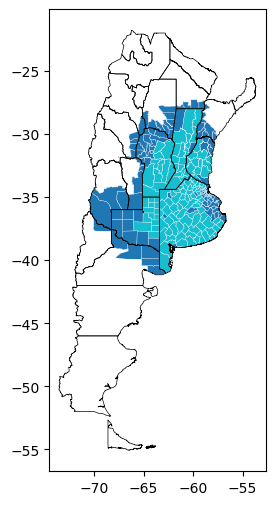

In [22]:
name_filter = wheat["name"].unique().tolist()
gdf_adm2_temp = gdf_adm2.copy()

gdf_adm2_temp["complete_yield_series"] = gdf_adm2_temp["name"].apply(lambda x: "yes" if x in name_filter else "no")

base = gdf_adm2_temp.plot(figsize=(6,6), column="complete_yield_series", edgecolor="white", linewidth=.2)
gdf_adm1_raw.plot(ax=base,  color="#FF000000", edgecolor="black", linewidth=0.5)

In [31]:
gdf_adm2_temp = gdf_adm2_temp.loc[gdf_adm2_temp["complete_yield_series"] == "yes"].reset_index(drop=True)
era = pd.read_csv("data/ERA/era.csv")
era = gp.GeoDataFrame(era, geometry=gp.points_from_xy(era["lon"], era["lat"], crs="EPSG:4326"))
era_coordinates = era.groupby(["lat", "lon"]).agg({"geometry":"first"}).reset_index()
era_coordinates = gp.GeoDataFrame(era_coordinates, geometry="geometry", crs="EPSG:4326")
era_coordinates = gp.sjoin(era_coordinates, gdf_adm2_temp).reset_index(drop=True)[["lat", "lon", "geometry", "name"]]
era = era_coordinates[["lat", "lon", "name"]].merge(era, left_on=["lat", "lon"], right_on=["lat", "lon"], how="left")
era.head()
#era_filtered = era.loc[era["month"].between(5,11)]

,lat,lon,name,time,rain,tmean,month,year,geometry
0,-40.9,-62.8,buenos aires patagones,1993-01-01,0.000416,20.79,1,1993,POINT (-62.80000 -40.90000)
1,-40.9,-62.8,buenos aires patagones,1993-02-01,0.000564,22.15,2,1993,POINT (-62.80000 -40.90000)
2,-40.9,-62.8,buenos aires patagones,1993-03-01,0.000609,19.90,3,1993,POINT (-62.80000 -40.90000)
3,-40.9,-62.8,buenos aires patagones,1993-04-01,0.001395,14.66,4,1993,POINT (-62.80000 -40.90000)
4,-40.9,-62.8,buenos aires patagones,1993-05-01,0.001343,10.81,5,1993,POINT (-62.80000 -40.90000)


<Axes: >

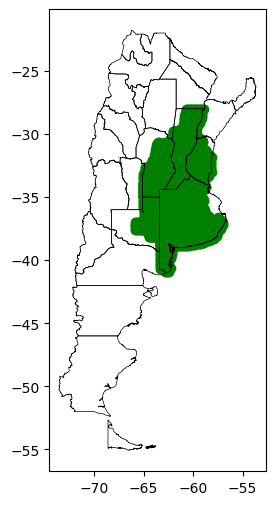

In [37]:
base = era_coordinates.plot(figsize=(6,6), color="green")
gdf_adm1_raw.plot(ax=base,  color="#FF000000", edgecolor="black", linewidth=0.5)

In [48]:
weather_features = era.groupby(["year", "month"]).agg({"rain":"sum", "tmean":"mean"}).reset_index().pivot(index="year", columns="month", values=["rain", "tmean"]).round(2)
weather_features.columns = [str(s[0]) + "_" + str(s[1]) for s in weather_features.columns]

weather_features = weather_features.reset_index()

In [50]:
weather_features.to_csv("data/weather_features_era.csv", index=False)